# WSB SCRAPER

## 1) Load packages

In [2]:
import datetime
import pyarrow
import praw
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marku\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 2) Set up Reddit API

In [3]:
# DISCLAIMER: this is not my API key, I have it from some tutorial, but can't find the link anymore. Sorry!
reddit = praw.Reddit(client_id='dwvhQN_PoUCoAw',
                     client_secret='X8N_SZUsiI-CNVIYLToBFFQ-cYE',
                     user_agent='news on hooks')

## 3) Retrieve data

### 3.1) Retrieve submissions

In [83]:
n_depth = 5
submissions = reddit.subreddit('wallstreetbets').new(limit = n_depth)

### 3.2) Parse submissions

In [84]:
sub_data = pd.DataFrame(columns = ['id', 'title', 'author', 'score', 'flair', 'ncomms', 'created', 'body', 'vader'])
for sub in submissions:
    sub_data = sub_data.append(
    pd.Series(
    [
        sub.id, 
        sub.title, 
        sub.author,
        sub.score,
        sub.link_flair_text, 
        sub.num_comments,
        sub.created_utc,
        sub.selftext,
        'N/A'
    ], 
    index = ['id', 'title', 'author', 'score', 'flair', 'ncomms', 'created', 'body', 'vader']
    ),
        ignore_index = True
    )
sub_data

,id,title,author,score,flair,ncomms,created,body,vader
0,kr8tdo,learning options Greeks for dummies,Ouiju,1,Meme,0,1.609884e+09,,N/A
1,kr8tck,"All the PLTR bear ""analysts"" are out of touch ...",Rocketpod_,3,DD,0,1.609884e+09,"Imagine if you got in to Tesla, Amazon, Google...",N/A
2,kr8sbz,TSLA Curiosity,stickman07738,1,News,0,1.609884e+09,I just saw this news report and always thought...,N/A
3,kr8mnj,Why you should buy $LIT,ohbabyspence,1,DD,1,1.609883e+09,"Hello again fellow retards, I am here to preac...",N/A
4,kr8ir9,$PLTR co founder John Lonsdale 8VC firm owns a...,religionresearcher,3,Discussion,6,1.609883e+09,So they totally aped into $WISH with 30m plus ...,N/A


### 3.3) Retrieve comment forrest

In [85]:
com_data =  pd.DataFrame(columns = ['id', 'subid', 'parentid', 'author', 'score', 'created', 'body', 'vader'])
for s_id in sub_data.id:
    sub = reddit.submission(id=s_id)
    print(sub.title)
    sub.comments.replace_more(limit=None)
    comment_queue = sub.comments[:]  # Seed with top-level
    while comment_queue:
        comment = comment_queue.pop(0)
        com_data = com_data.append(
        pd.Series(
        [
            comment.id, 
            comment.link_id,
            comment.parent_id,
            comment.author,
            comment.score,
            comment.created_utc,
            comment.body,
            'N/A'
        ],
            index = ['id', 'subid', 'parentid', 'author', 'score', 'created', 'body', 'vader']
        ),
            ignore_index = True
        )
        comment_queue.extend(comment.replies)
        
com_data

learning options Greeks for dummies
All the PLTR bear "analysts" are out of touch and have no idea what they're talking about
TSLA Curiosity
Why you should buy $LIT
$PLTR co founder John Lonsdale 8VC firm owns a yolo amount of $WISH


,id,subid,parentid,author,score,created,body,vader
0,gi899e9,t3_kr8mnj,t3_kr8mnj,pickbot,2,1.609883e+09,**I am a bot and identified and tracked the fo...,N/A
1,gi87qws,t3_kr8ir9,t3_kr8ir9,WSBVoteBot,1,1.609883e+09,**I am a bot. Is this submission violating the...,N/A
2,gi89127,t3_kr8ir9,t3_kr8ir9,BagofBabbish,4,1.609883e+09,"Hate to break it to you, but venture firms ALW...",N/A
3,gi88wti,t3_kr8ir9,t3_kr8ir9,noselfinterest,2,1.609883e+09,there was a recent post on how bad/crap WISH i...,N/A
4,gi882qc,t3_kr8ir9,t3_kr8ir9,kleyva24,2,1.609883e+09,Son of a gun. Im all in. 🚀 didnt even have to ...,N/A
5,gi89m2i,t3_kr8ir9,t1_gi89127,uslashuname,1,1.609884e+09,Right? Like the guys that sold aapl at ipo for...,N/A
6,gi89z7c,t3_kr8ir9,t1_gi88wti,ChicknNugBuds,1,1.609884e+09,I just think about that retard buying a ps5 on...,N/A


## 4) VADER Sentiment Analyzer

### 4.1) Assign SIA shortcut

In [86]:
sia = SentimentIntensityAnalyzer()

### 4.2) Define custom valence dictionary

In [87]:
wsb_lingo = {
    # words to neutralize
    'retard': 0,
    'yolo': 0,
    'yolod': 0,
    'yoloed': 0,
    'yoloing': 0,
    'fuck': 0,
    'fucks': 0,
    'fucked': 0,
    'fucking': 0,
    'shit': 0,
    'fag': 0, 
    'autist': 0,
    # positive valence
    'bull': 1.5,
    'call': 1.5,
    'calls': 1.5,
    'long': 1.5,
    'buy': 1,
    'buys': 1,
    'buying': 1,
    'hold': 0.5,
    # negative valence
    'bear': -1.5,
    'sell': -1.5,
    'selling': -1.5,
    'sells': -1.5,
    'puts': -1.5,
    'short': -1.5,
    'shorts': -1.5,
    'shorting': -1.5,
    'put': -1,
    'wife': -1,
    "wife's": -1,
    'boyfriend': -1,
    'gay': -0.5, # sad
    'moon': -0.5, # debatable, but mostly used sarcastically
    # emoji mapping, which get translated to text by VADER
    'fire': 0,
    'rainbow': -1.5,
    'gem stone': 1,
    'raising hand': 1,
    'rocket': 1.5
}

sia.lexicon.update(wsb_lingo)

### 4.3) Iterate over submissions and comments

In [88]:
for row in sub_data.index:
    sub_data.loc[row, 'vader'] = sia.polarity_scores(sub_data.loc[row, 'title'])['compound']
sub_data

,id,title,author,score,flair,ncomms,created,body,vader
0,kr8tdo,learning options Greeks for dummies,Ouiju,1,Meme,0,1.609884e+09,,0
1,kr8tck,"All the PLTR bear ""analysts"" are out of touch ...",Rocketpod_,3,DD,0,1.609884e+09,"Imagine if you got in to Tesla, Amazon, Google...",-0.5719
2,kr8sbz,TSLA Curiosity,stickman07738,1,News,0,1.609884e+09,I just saw this news report and always thought...,0
3,kr8mnj,Why you should buy $LIT,ohbabyspence,1,DD,1,1.609883e+09,"Hello again fellow retards, I am here to preac...",0.25
4,kr8ir9,$PLTR co founder John Lonsdale 8VC firm owns a...,religionresearcher,3,Discussion,6,1.609883e+09,So they totally aped into $WISH with 30m plus ...,0


In [89]:
for row in com_data.index:
    com_data.loc[row, 'vader'] = sia.polarity_scores(com_data.loc[row, 'body'])['compound']
com_data

,id,subid,parentid,author,score,created,body,vader
0,gi899e9,t3_kr8mnj,t3_kr8mnj,pickbot,2,1.609883e+09,**I am a bot and identified and tracked the fo...,0
1,gi87qws,t3_kr8ir9,t3_kr8ir9,WSBVoteBot,1,1.609883e+09,**I am a bot. Is this submission violating the...,-0.6662
2,gi89127,t3_kr8ir9,t3_kr8ir9,BagofBabbish,4,1.609883e+09,"Hate to break it to you, but venture firms ALW...",-0.4215
3,gi88wti,t3_kr8ir9,t3_kr8ir9,noselfinterest,2,1.609883e+09,there was a recent post on how bad/crap WISH i...,0.5754
4,gi882qc,t3_kr8ir9,t3_kr8ir9,kleyva24,2,1.609883e+09,Son of a gun. Im all in. 🚀 didnt even have to ...,-0.34
5,gi89m2i,t3_kr8ir9,t1_gi89127,uslashuname,1,1.609884e+09,Right? Like the guys that sold aapl at ipo for...,0.8074
6,gi89z7c,t3_kr8ir9,t1_gi88wti,ChicknNugBuds,1,1.609884e+09,I just think about that retard buying a ps5 on...,0.7351


## 5) Store Data

### 5.1) Data type fixing

In [90]:
sub_data = sub_data.astype({'id': 'str', # required str conversion due to hidden PRAW-specific dtypes incompatibility with feather
                            'title': 'str',
                            'author': 'str',
                            'score': 'int32', 
                            'flair': 'str',
                            'ncomms': 'int32', 
                            'created': 'datetime64[s]',
                            'body': 'str',
                            'vader': 'float32'})
sub_data.dtypes

id                 object
title              object
author             object
score               int32
flair              object
ncomms              int32
created    datetime64[ns]
body               object
vader             float32
dtype: object

In [91]:
com_data = com_data.astype({'id': 'str',
                            'subid': 'str',
                            'parentid': 'str',
                            'author': 'str',
                            'score': 'int32', 
                            'created': 'datetime64[s]',
                            'body': 'str',
                            'vader': 'float32'})
com_data.dtypes

id                  object
subid               object
parentid            object
author              object
score                int32
created     datetime64[ns]
body                object
vader              float32
dtype: object

### 5.2) Save history

In [92]:
sub_data.to_feather(f'www/history/sub_data_{datetime.datetime.now():%Y%m%d_%H%M}.ft')
com_data.to_feather(f'www/history/com_data_{datetime.datetime.now():%Y%m%d_%H%M}.ft')

### 5.3) Splice history

In [93]:
sub_wc = pd.read_feather('www/sub_data.ft')
com_wc = pd.read_feather('www/com_data.ft')

In [94]:
sub_key = pd.merge(sub_data, sub_wc, how = 'outer')
com_key = pd.merge(com_data, com_wc, how = 'outer')

In [105]:
sub_key = pd.merge(sub_data['id'], sub_wc['id'], how = 'outer').drop_duplicates()
sub_key = pd.merge(sub_key, sub_data, how = 'outer', on = 'id').dropna(how = 'any')
sub_data = pd.merge(sub_key, pd.merge(sub_key[pd.isnull(sub_key['title'])]['id'], sub_wc, how = 'outer', on = 'id'), how = 'outer')
com_key = pd.merge(com_data['id'], com_wc['id'], how = 'outer').drop_duplicates()
com_key = pd.merge(com_key, com_data, how = 'outer', on = 'id').dropna(how = 'any')
com_data = pd.merge(com_key, pd.merge(com_key[pd.isnull(com_key['subid'])]['id'], com_wc, how = 'outer', on = 'id'), how = 'outer')

### 5.4) Save working copy

In [106]:
sub_data.to_feather('www/sub_data.ft')
com_data.to_feather('www/com_data.ft')

# See you in R! 
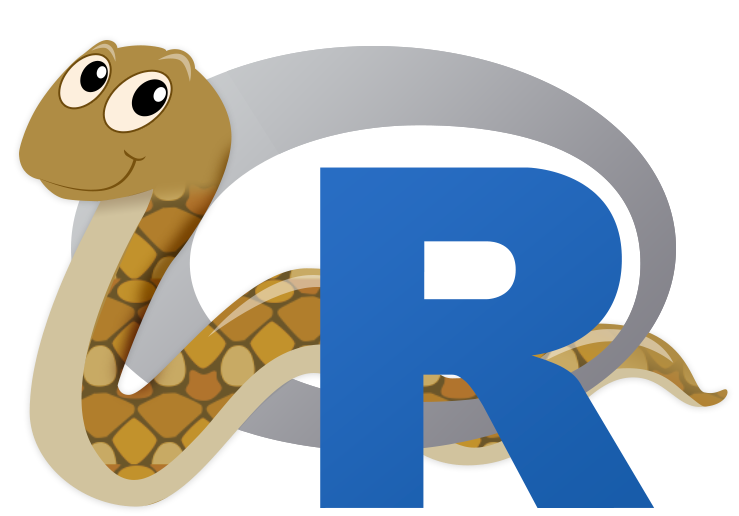